### Neural Network - Physics
Our goal in this notebook is to learn how to use Tensorflow Keras and neural networks by using it to model a basic physics equation. The physics equation to be used is that of kinetic energy: `1/2 mv^2`

Why do this?
- The physics equation is well known already, so we don't have to worry about error functions for now and can focus solely on neural networks and their performance.
- The physics equation is simple with few moving parts/variables, therefore we'll be using a simple neural network too.
- There is a given equation, which can be used to generate our data. This simplifies our data gathering process and we won't have to worry about errors due to noise or measurement in our data.
- Since we only have a simple model we're trying to create, we can also experiment on the number of layers used, the number of nodes for each of those layers, the activation functions to use for those layers, and the type of network structure to use. We can then compare and see which combinations work better than others for this particular problem.

Now that we get that out of the way, let's get to creating neural networks!

In [166]:
import numpy as np

# Here's our simple physics equation!
def GetOutput(m, v):
    return 0.5 * m * v**2

trainSize = 7000
testSize = 3000
dataSize = trainSize + testSize
inputs = []
outputs = []
for i in range(dataSize):
    m = np.random.uniform(1, 50)
    v = np.random.uniform(1, 25)
    ek = GetOutput(m, v)
    inputs.append([m, v])
    outputs.append([ek])
    
inputs = np.asarray(inputs)
outputs = np.asarray(outputs)

In [167]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

inputScaler = StandardScaler()
inputScaler.fit(inputs)
inputs = scaler.transform(inputs)

outputScaler = StandardScaler()
outputScaler.fit(outputs)
outputs = outputScaler.transform(outputs)[:, 0]

trainInputs = inputs[:trainSize]
trainOutputs = outputs[:trainSize]
testInputs = inputs[trainSize:]
testOutputs = outputs[trainSize:]

# Defining the model, 2 hidden layers with relu activation and 1 output layer
model = Sequential()
model.add(Dense(8, input_dim=2, kernel_initializer='he_uniform', activation="relu"))
model.add(Dense(4, activation="relu"))
model.add(Dense(1, activation="linear"))

opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss="mse", optimizer=opt)

history = model.fit(trainInputs, trainOutputs, validation_data=(testInputs, testOutputs), epochs=100, verbose=0)
trainMSE = model.evaluate(trainInputs, trainOutputs, verbose=0)
testMSE = model.evaluate(testInputs, testOutputs, verbose=0)

print("Train:", trainMSE, ", Test:", testMSE)

Train: 0.000729546882212162 , Test: 0.0007153786718845367


In [103]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
from cycler import cycler

matplotlib.style.use("dark_background")
%matplotlib inline
rcParams["figure.figsize"] = (15, 6)
rcParams["axes.prop_cycle"] = cycler(color=["#4299E1", "#F56565", "#48BB78"])
rcParams["axes.facecolor"] = "#1A202C"
rcParams["axes.edgecolor"] = "#A0AEC0"
rcParams["axes.grid"] = True
rcParams["grid.color"] = "#A0AEC0"
rcParams["grid.alpha"] = 0.7
rcParams["axes.titlecolor"] = "#A0AEC0"
rcParams["axes.labelcolor"] = "#A0AEC0"
rcParams["xtick.color"] = "#A0AEC0"
rcParams["ytick.color"] = "#A0AEC0"

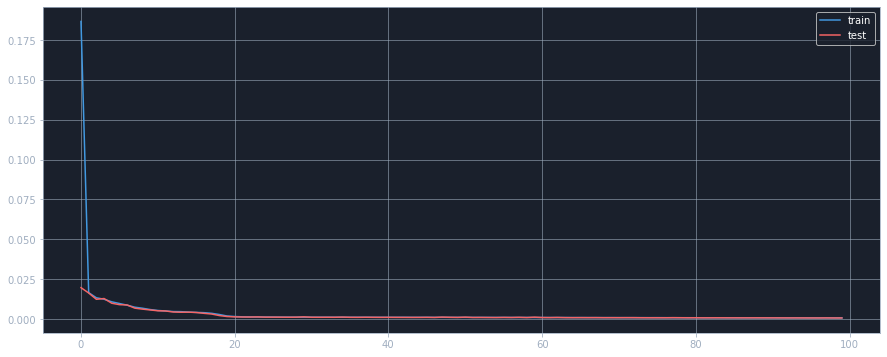

In [168]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

In [214]:
m = 20
v = 16

i = np.array([[m, v]])

prediction = outputScaler.inverse_transform(model.predict(inputScaler.transform(i)))[0, 0]
actual = GetOutput(m, v)
print("Prediction: ", prediction, "\nActual:", actual, "\nRelative Error:", abs(actual - prediction) / actual)

Prediction:  2481.5806 
Actual: 2560.0 
Relative Error: 0.030632591247558592
